In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/newmm.csv')
mbs = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/mbs_person_summary.csv')
pbs = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/pbs_person_summary.csv')
drug = pd.read_csv('/content/drive/My Drive/Medicare Analysis/Data/pbs_item_manufacturer.csv')
datambs = pd.merge(df, mbs.drop(['last_mbs', 'sex','yob','Unnamed: 0','ptnt_state', 'lastcontact'], axis = 1), left_on='pin', right_on='pin', how='left')
data = pd.merge(datambs, pbs.drop(['last_pbs', 'sex','yob','Unnamed: 0','nstate', 'lastcontact'], axis = 1), left_on='pin', right_on='pin', how='left')\
            .drop(['No', 'last_pbs', 'last_mbs', 'MMGrouping', 'Lastservice', 'disDays'], axis =1)

data.loc[(0 <= data.age) & (data.age <= 14),'Agegrouping']='0-14'
data.loc[(15 <= data.age) & (data.age <= 24),'Agegrouping']='15-24'
data.loc[(25 <= data.age) & (data.age <= 34),'Agegrouping']='25-34'
data.loc[(35 <= data.age) & (data.age <= 44),'Agegrouping']='35-44'
data.loc[(45 <= data.age) & (data.age <= 54),'Agegrouping']='45-54'
data.loc[(55 <= data.age) & (data.age <= 64),'Agegrouping']='55-64'
data.loc[(65 <= data.age) & (data.age <= 74),'Agegrouping']='65-74'
data.loc[(75 <= data.age) & (data.age <= 84),'Agegrouping']='75-84'
data.loc[(85 <= data.age) & (data.age <= 100),'Agegrouping']='85-100'

data.dropna(inplace=True)

# Create firstcontactage features
data[['firstcontact_x','firstcontact_y']] = pd.to_datetime(data[['firstcontact_x','firstcontact_y']].stack(), format = '%Y-%m-%d').unstack()
data['firstcontact_x'] = pd.DatetimeIndex(data['firstcontact_x']).year
data['firstcontactage_x'] = data['firstcontact_x'] - data['yob']
data['firstcontact_y'] = pd.DatetimeIndex(data['firstcontact_y']).year
data['firstcontactage_y'] = data['firstcontact_y'] - data['yob']
data['totalbenpaid'] = data['totalbenpaid'].replace('[\$,]', '', regex=True).astype(float)

# Redefine feature type
data[['nrecords_x']] = data[['nrecords_x']].astype('int64')

# 1. Overview

In [ ]:
data.shape

(346182, 28)

In [ ]:
data.head()

,pin,yob,sex,age,GroupingA10,GroupingC0,GroupingC10,Concatenate,Agegrouping,dead,nrecords_x,firstcontact_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,ptnt_state,nrecords_y,firstcontact_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y,firstcontactage_x,firstcontactage_y
0,7275102840,1924,M,80,A10,C0,No,A10C0No,75-84,YES,118,1984,1.0,256930.0,287000.0,"$252,645.00",99.0,9951.0,VIC,80,2004,11,1955.97,384.60,80,2630,60,80
1,316560614,1925,F,79,No,C0,No,NoC0No,75-84,NO,778,1984,1.0,4356900.0,3690900.0,"$3,199,140.00",656.0,11233.0,VIC,325,2003,46,7112.05,1633.76,325,4367,59,78
2,1706657926,1919,F,85,No,C0,No,NoC0No,85-100,YES,304,1984,2.0,609220.0,714360.0,"$607,930.00",304.0,6898.0,QLD,3,2003,3,92.60,12.10,3,701,65,84
3,9352250463,1971,F,33,No,C0,No,NoC0No,25-34,NO,1548,1984,2.0,4990480.0,4982320.0,"$4,457,090.00",1255.0,11043.0,SA,1296,2003,74,31417.87,4149.50,1296,4380,13,32
4,6529626350,1944,F,60,No,C0,No,NoC0No,55-64,NO,250,1986,1.0,713230.0,743615.0,"$661,975.00",193.0,10251.0,NSW,414,2003,17,13493.79,1413.00,414,4304,42,59


In [6]:
dead = data[(data['dead']=='YES')]
dead.describe()

,pin,yob,age,nrecords_x,firstcontact_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,nrecords_y,firstcontact_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y,firstcontactage_x,firstcontactage_y
count,9.316400e+04,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,9.316400e+04,9.316400e+04,9.316400e+04,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000,93164.000000
mean,5.006767e+09,1930.185318,73.814682,689.858078,1984.908377,1.128698,2.704770e+06,2.679552e+06,2.286385e+06,611.547851,8862.811268,341.240286,2003.036130,34.634301,11818.131582,1319.019223,342.847591,2292.368082,54.723058,72.850811
std,2.877562e+09,13.671157,13.671157,475.410293,2.789157,0.377878,2.255788e+06,2.045474e+06,1.707869e+06,424.335051,1524.069375,286.658182,0.186614,21.129880,15102.311384,1120.466103,287.381546,1131.949474,13.195276,13.630973
min,2.622500e+04,1904.000000,0.000000,1.000000,1984.000000,1.000000,1.055000e+03,1.240000e+03,1.055000e+03,1.000000,0.000000,1.000000,2003.000000,1.000000,0.740000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.520567e+09,1921.000000,67.000000,364.000000,1984.000000,1.000000,1.225268e+06,1.296695e+06,1.121672e+06,325.000000,7957.000000,128.000000,2003.000000,19.000000,3106.892500,516.475000,129.000000,1314.000000,48.000000,67.000000
50%,5.013989e+09,1928.000000,76.000000,587.000000,1984.000000,1.000000,2.095290e+06,2.181095e+06,1.879805e+06,518.000000,8986.000000,267.000000,2003.000000,31.000000,7584.935000,1060.050000,269.000000,2314.000000,57.000000,75.000000
75%,7.499011e+09,1937.000000,83.000000,895.000000,1984.000000,1.000000,3.480032e+06,3.488075e+06,2.990141e+06,788.000000,10019.000000,479.000000,2003.000000,47.000000,15432.865000,1831.700000,481.000000,3292.000000,64.000000,82.000000
max,9.999875e+09,2004.000000,100.000000,9072.000000,2007.000000,5.000000,4.600790e+07,4.397380e+07,3.431734e+07,8913.000000,11122.000000,3949.000000,2004.000000,195.000000,546951.310000,20574.200000,3951.000000,4202.000000,94.000000,99.000000


In [7]:
alive = data[(data['dead']=='NO')]
alive.describe()

,pin,yob,age,nrecords_x,firstcontact_x,nstate,totalfeecharged,totalschedfee,totalbenpaid,totalnumserv,lengthcontact_x,nrecords_y,firstcontact_y,n_pbs_code,total_bnft_amt,total_ptnt_cntrbtn_amt,total_prscrptn_cnt,lengthcontact_y,firstcontactage_x,firstcontactage_y
count,2.530180e+05,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,2.530180e+05,2.530180e+05,2.530180e+05,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000,253018.000000
mean,5.000984e+09,1944.630350,59.369650,702.874898,1985.101206,1.172565,3.053964e+06,2.867813e+06,2.500256e+06,597.705021,10752.096116,428.527468,2003.061830,34.124149,14005.052503,2718.271438,431.608419,4274.821708,40.470856,58.431479
std,2.887612e+09,13.639165,13.639165,464.448156,3.037422,0.443433,2.303401e+06,2.072192e+06,1.788010e+06,389.797230,1135.198337,332.827631,0.240846,22.203591,18489.048121,1851.496851,334.718054,250.975019,13.160942,13.592738
min,1.076970e+05,1914.000000,0.000000,5.000000,1984.000000,1.000000,1.300500e+04,1.528500e+04,1.300500e+04,5.000000,818.000000,1.000000,2003.000000,1.000000,0.020000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.496161e+09,1935.000000,52.000000,382.000000,1984.000000,1.000000,1.504440e+06,1.448832e+06,1.271676e+06,334.000000,10908.000000,179.000000,2003.000000,17.000000,3909.315000,1518.010000,180.000000,4306.000000,33.000000,51.000000
50%,5.001343e+09,1943.000000,61.000000,595.000000,1984.000000,1.000000,2.476200e+06,2.373700e+06,2.077415e+06,508.000000,11147.000000,351.000000,2003.000000,30.000000,9467.130000,2312.110000,354.000000,4349.000000,41.000000,60.000000
75%,7.503906e+09,1952.000000,69.000000,900.000000,1984.000000,1.000000,3.929408e+06,3.715255e+06,3.242481e+06,756.000000,11233.000000,594.000000,2003.000000,46.000000,17851.835000,3377.082500,598.000000,4364.000000,50.000000,68.000000
max,9.999956e+09,2004.000000,90.000000,12733.000000,2007.000000,6.000000,6.790990e+07,6.512320e+07,6.363446e+07,12285.000000,11305.000000,5118.000000,2004.000000,228.000000,582172.260000,27233.750000,5493.000000,4382.000000,85.000000,89.000000


In [8]:
cat_data = data[['pin','Agegrouping','Concatenate','GroupingA10', 'GroupingC10', 
         'GroupingC0', 'dead','ptnt_state']]

In [9]:
cat_dead = cat_data[(cat_data['dead']=='YES')]
for col in cat_dead.columns[1:]:
  print(cat_dead.groupby(col)['pin'].nunique()/93164*100)
  print('\n')

Agegrouping
0-14       0.528101
15-24      0.415397
25-34      0.741703
35-44      1.794685
45-54      4.767936
55-64     11.434674
65-74     23.839681
75-84     36.708385
85-100    19.769439
Name: pin, dtype: float64


Concatenate
A10C0C10     9.377013
A10C0No      6.323258
A10NoC10     0.729896
A10NoNo      2.096303
NoC0C10     26.164613
NoC0No      48.541282
NoNoC10      6.767636
Name: pin, dtype: float64


GroupingA10
A10    18.526469
No     81.473531
Name: pin, dtype: float64


GroupingC10
C10    43.039157
No     56.960843
Name: pin, dtype: float64


GroupingC0
C0    90.406165
No     9.593835
Name: pin, dtype: float64


dead
YES    100.0
Name: pin, dtype: float64


ptnt_state
NSW    36.358465
QLD    17.550771
SA      9.372719
UNK     0.047229
VIC    28.165386
WA      8.505431
Name: pin, dtype: float64




In [10]:
cat_alive = cat_data[(cat_data['dead']=='NO')]
for col in cat_alive.columns[1:]:
  print(cat_alive.groupby(col)['pin'].nunique()/253018*100)
  print('\n')

Agegrouping
0-14       1.085694
15-24      1.134307
25-34      2.308136
35-44      7.527132
45-54     19.612439
55-64     30.184809
65-74     26.316705
75-84     11.077868
85-100     0.752911
Name: pin, dtype: float64


Concatenate
A10C0C10     5.933570
A10C0No      3.193449
A10NoC10     1.234695
A10NoNo      3.138512
NoC0C10     25.687500
NoC0No      42.596574
NoNoC10     18.215700
Name: pin, dtype: float64


GroupingA10
A10    13.500225
No     86.499775
Name: pin, dtype: float64


GroupingC10
C10    51.071465
No     48.928535
Name: pin, dtype: float64


GroupingC0
C0    77.411093
No    22.588907
Name: pin, dtype: float64


dead
NO    100.0
Name: pin, dtype: float64


ptnt_state
NSW    37.032148
QLD    17.277032
SA      8.714400
UNK     0.049008
VIC    27.959276
WA      8.968137
Name: pin, dtype: float64




# 2. Explorotary Data Analysis

## Dead cohort

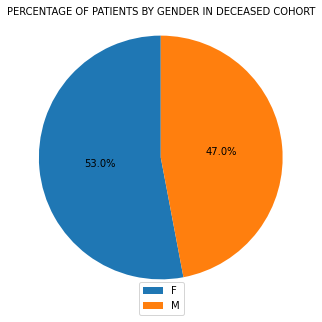

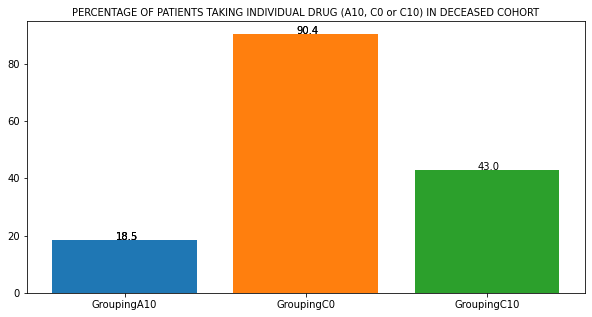

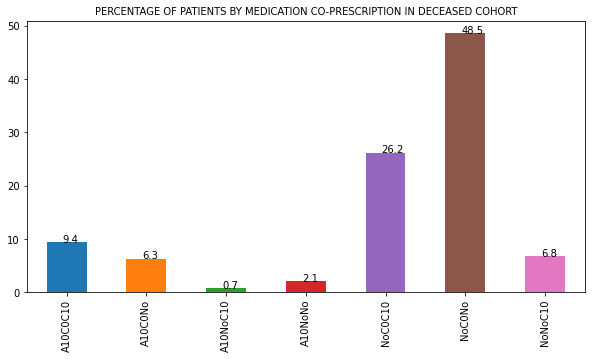

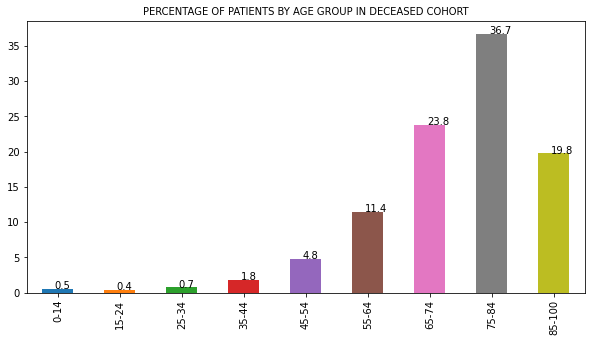

In [19]:
patient = dead[['sex']]
patient = pd.pivot_table(patient, index=['sex'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(dead)*100
plt.figure(figsize=(10,5))
plt.pie(patient['(%)'], labeldistance = .53, pctdistance = .5, autopct='%1.1f%%', startangle=90)
plt.legend(genders, loc="lower center", bbox_to_anchor=(.50,-.1))
plt.axis('square')
plt.title('PERCENTAGE OF PATIENTS BY GENDER IN DECEASED COHORT', fontsize=10)
plt.xlabel('')
plt.show()

dead_groups = []
for col, value in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], ['A10', 'C0', 'C10']):
    dead_groups.append(dead[dead[col] == value])

plt.figure(figsize=(10,5))
heights = []
for col, i in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], range(3)):
    plt.bar(x = col, height = dead_groups[i].pin.count()/len(dead)*100)
    heights.append(dead_groups[i].pin.count()/len(dead)*100)
    for i, v in zip(range(3), heights):
        plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.title('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) IN DECEASED COHORT', fontsize=10)
plt.show()

patient = dead[['Concatenate']]
patient = pd.pivot_table(patient, index=['Concatenate'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(dead)*100
patient['(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(patient['(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.title('PERCENTAGE OF PATIENTS BY MEDICATION CO-PRESCRIPTION IN DECEASED COHORT', fontsize=10)
plt.xlabel('')
plt.show()

patient = dead[['Agegrouping']]
patient = pd.pivot_table(patient, index=['Agegrouping'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(dead)*100
patient['(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(patient['(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.title('PERCENTAGE OF PATIENTS BY AGE GROUP IN DECEASED COHORT', fontsize=10)
plt.xlabel('')
plt.show()

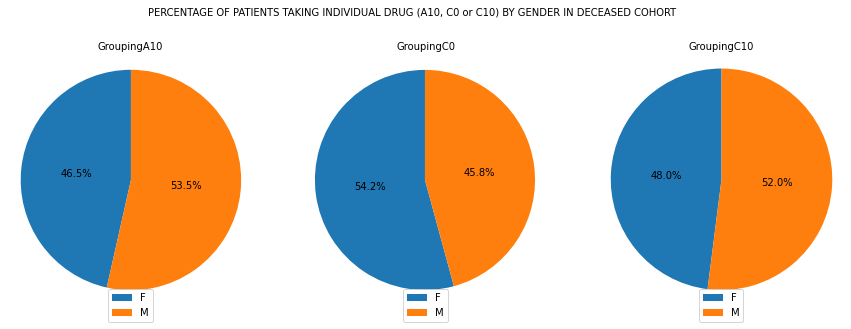

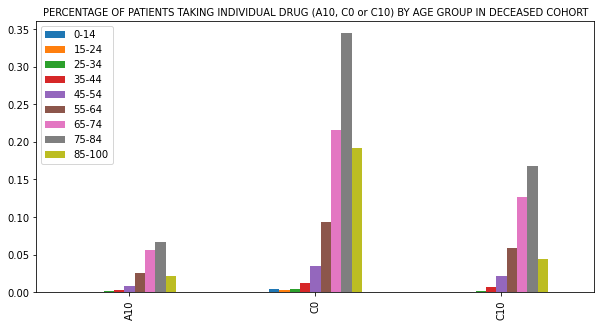

In [14]:
genders = []
counts = {}
for i, value in zip(range(3), ['A10', 'C0', 'C10']) :
    genders, counts['{}'.format(value)] = np.unique(dead_groups[i].sex, return_counts = True)
df = pd.DataFrame(counts, index = genders).T
dfp = pd.DataFrame().reindex_like(df)
for i in range(3):
    dfp.iloc[i] = [x/sum(df.iloc[i])*100 for x in df.iloc[i]]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) BY GENDER IN DECEASED COHORT', fontsize=10)
for each, value, ax in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], range(3), (ax1, ax2, ax3)):
    ax.pie(dfp.iloc[value], labeldistance = .53, pctdistance = .5, autopct='%1.1f%%', startangle=90)
    ax.legend(genders, loc="lower center", bbox_to_anchor=(.50,-.1))
    ax.set_title(each, loc='center', fontsize=10)
    ax.axis('square')

agegroups = []
counts = {}
for i, value in zip(range(3), ['A10', 'C0', 'C10']) :
    agegroups, counts['{}'.format(value)] = np.unique(dead_groups[i].Agegrouping, return_counts = True)
df = pd.DataFrame(counts, index = agegroups).T/len(dead)
df.plot.bar(figsize=(10,5))
plt.legend(loc='upper left')
plt.title('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) BY AGE GROUP IN DECEASED COHORT', fontsize=10)
plt.show()

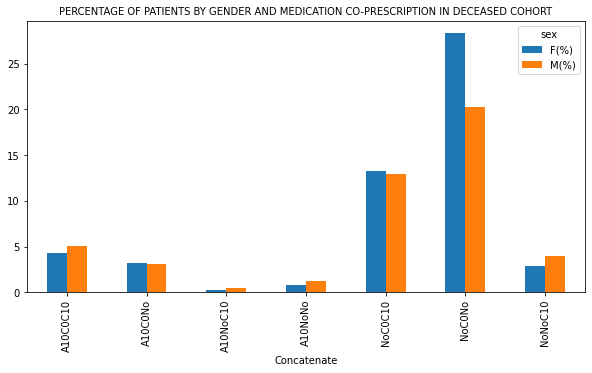

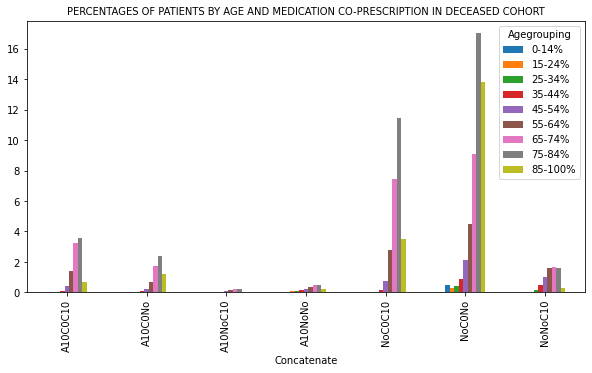

In [ ]:
med_sex = dead.groupby(['Concatenate','sex']).size().unstack(fill_value=0)
med_sex['F(%)'] = med_sex.iloc[:,0]/len(dead)*100
med_sex['M(%)'] = med_sex.iloc[:,1]/len(dead)*100
med_sex.iloc[:,2:].plot.bar(figsize=(10,5))
plt.title('PERCENTAGE OF PATIENTS BY GENDER AND MEDICATION CO-PRESCRIPTION IN DECEASED COHORT', fontsize=10)
plt.show()

med_age = dead.groupby(['Concatenate','Agegrouping']).size().unstack(fill_value=0)
for i, col in enumerate(med_age.columns):
  med_age[col+'%'] = med_age.iloc[:,i]/len(dead)*100
med_age.iloc[:,9:].plot.bar(figsize=(10,5))
plt.title('PERCENTAGES OF PATIENTS BY AGE AND MEDICATION CO-PRESCRIPTION IN DECEASED COHORT', fontsize=10)
plt.show()

## Alive cohort

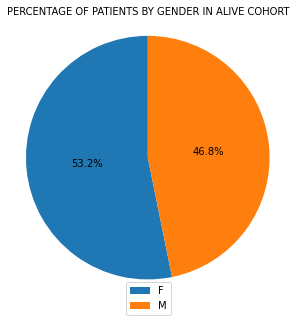

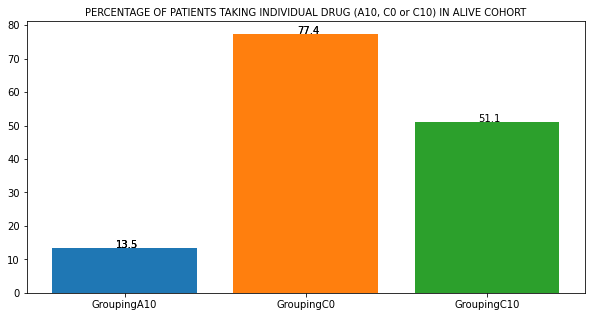

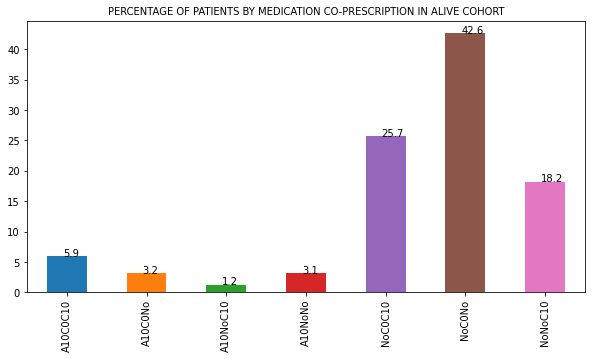

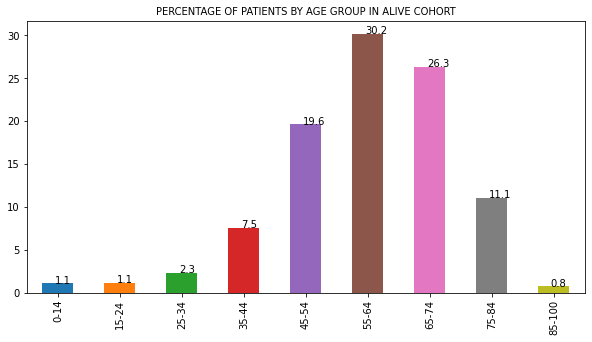

In [ ]:
patient = alive[['sex']]
patient = pd.pivot_table(patient, index=['sex'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(alive)*100
plt.figure(figsize=(10,5))
plt.pie(patient['(%)'], labeldistance = .53, pctdistance = .5, autopct='%1.1f%%', startangle=90)
plt.legend(genders, loc="lower center", bbox_to_anchor=(.50,-.1))
plt.axis('square')
plt.title('PERCENTAGE OF PATIENTS BY GENDER IN ALIVE COHORT', fontsize=10)
plt.xlabel('')
plt.show()

alive_groups = []
for col, value in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], ['A10', 'C0', 'C10']):
    alive_groups.append(alive[alive[col] == value])

plt.figure(figsize=(10,5))
heights = []
for col, i in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], range(3)):
    plt.bar(x = col, height = alive_groups[i].pin.count()/len(alive)*100)
    heights.append(alive_groups[i].pin.count()/len(alive)*100)
    for i, v in zip(range(3), heights):
        plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.title('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) IN ALIVE COHORT', fontsize=10)
plt.show()

patient = alive[['Concatenate']]
patient = pd.pivot_table(patient, index=['Concatenate'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(alive)*100
patient['(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(patient['(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.title('PERCENTAGE OF PATIENTS BY MEDICATION CO-PRESCRIPTION IN ALIVE COHORT', fontsize=10)
plt.xlabel('')
plt.show()

patient = alive[['Agegrouping']]
patient = pd.pivot_table(patient, index=['Agegrouping'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(alive)*100
patient['(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(patient['(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.title('PERCENTAGE OF PATIENTS BY AGE GROUP IN ALIVE COHORT', fontsize=10)
plt.xlabel('')
plt.show()

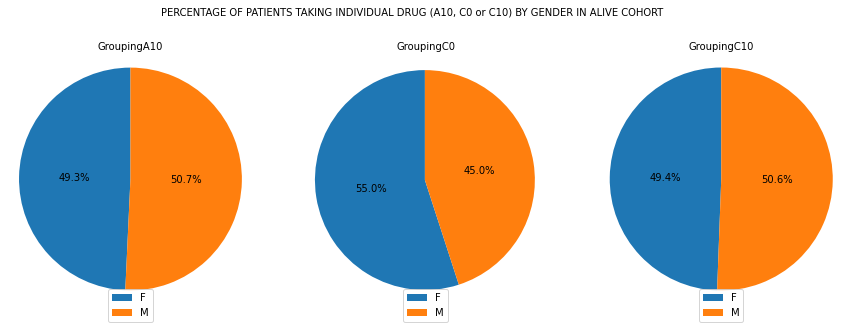

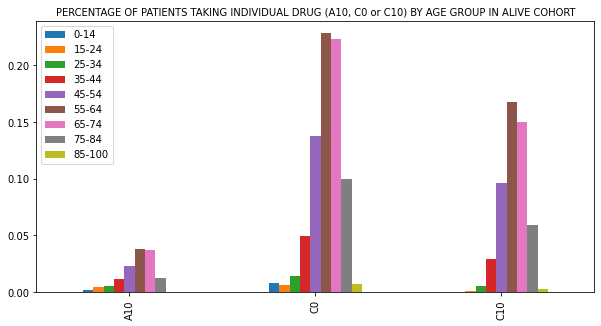

In [ ]:
genders = []
counts = {}
for i, value in zip(range(3), ['A10', 'C0', 'C10']) :
    genders, counts['{}'.format(value)] = np.unique(alive_groups[i].sex, return_counts = True)
df = pd.DataFrame(counts, index = genders).T
dfp = pd.DataFrame().reindex_like(df)
for i in range(3):
    dfp.iloc[i] = [x/sum(df.iloc[i])*100 for x in df.iloc[i]]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) BY GENDER IN ALIVE COHORT', fontsize=10)
for each, value, ax in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], range(3), (ax1, ax2, ax3)):
    ax.pie(dfp.iloc[value], labeldistance = .53, pctdistance = .5, autopct='%1.1f%%', startangle=90)
    ax.legend(genders, loc="lower center", bbox_to_anchor=(.50,-.1))
    ax.set_title(each, loc='center', fontsize=10)
    ax.axis('square')

agegroups = []
counts = {}
for i, value in zip(range(3), ['A10', 'C0', 'C10']) :
    agegroups, counts['{}'.format(value)] = np.unique(alive_groups[i].Agegrouping, return_counts = True)
df = pd.DataFrame(counts, index = agegroups).T/len(alive)
df.plot.bar(figsize=(10,5))
plt.legend(loc='upper left')
plt.title('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) BY AGE GROUP IN ALIVE COHORT', fontsize=10)
plt.show()

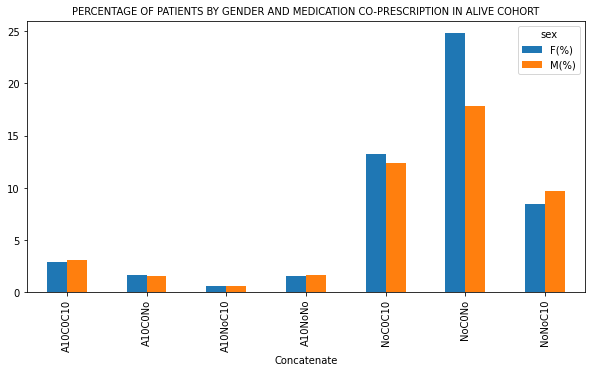

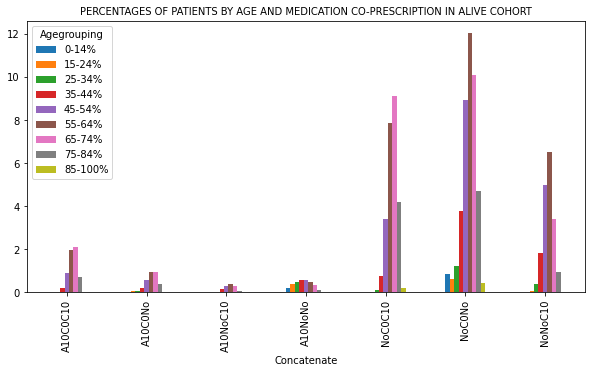

In [ ]:
med_sex = alive.groupby(['Concatenate','sex']).size().unstack(fill_value=0)
med_sex['F(%)'] = med_sex.iloc[:,0]/len(alive)*100
med_sex['M(%)'] = med_sex.iloc[:,1]/len(alive)*100
med_sex.iloc[:,2:].plot.bar(figsize=(10,5))
plt.title('PERCENTAGE OF PATIENTS BY GENDER AND MEDICATION CO-PRESCRIPTION IN ALIVE COHORT', fontsize=10)
plt.show()

med_age = alive.groupby(['Concatenate','Agegrouping']).size().unstack(fill_value=0)
for i, col in enumerate(med_age.columns):
  med_age[col+'%'] = med_age.iloc[:,i]/len(alive)*100
med_age.iloc[:,9:].plot.bar(figsize=(10,5))
plt.title('PERCENTAGES OF PATIENTS BY AGE AND MEDICATION CO-PRESCRIPTION IN ALIVE COHORT', fontsize=10)
plt.show()

## Whole population

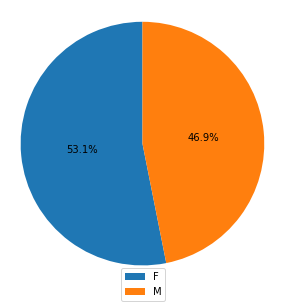

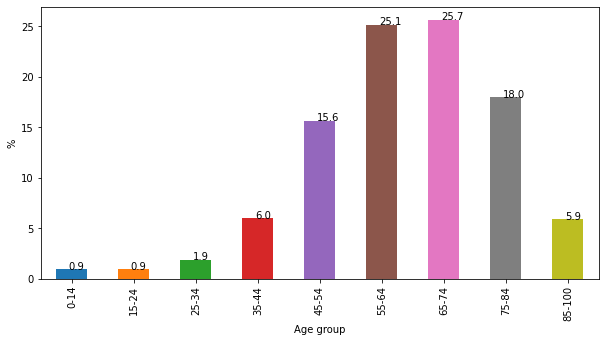

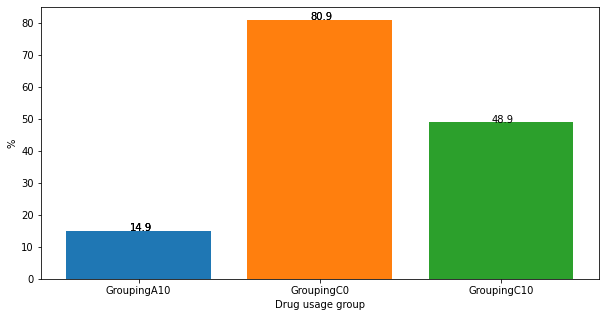

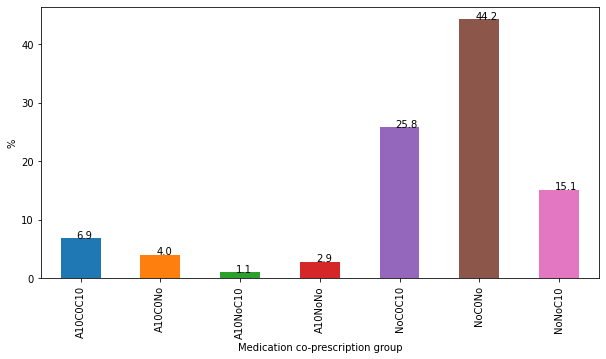

In [21]:
patient = data[['sex']]
patient = pd.pivot_table(patient, index=['sex'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(data)*100
plt.figure(figsize=(10,5))
plt.pie(patient['(%)'], labeldistance = .53, pctdistance = .5, autopct='%1.1f%%', startangle=90)
plt.legend(genders, loc="lower center", bbox_to_anchor=(.50,-.1))
plt.axis('square')
plt.xlabel('')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig1.pdf')
plt.show()

patient = data[['Agegrouping']]
patient = pd.pivot_table(patient, index=['Agegrouping'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(data)*100
patient['(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(patient['(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.xlabel('Age group')
plt.ylabel('%')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig2.pdf')
plt.show()

groups = []
for col, value in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], ['A10', 'C0', 'C10']):
    groups.append(data[data[col] == value])

plt.figure(figsize=(10,5))
heights = []
for col, i in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], range(3)):
    plt.bar(x = col, height = groups[i].pin.count()/len(data)*100)
    heights.append(groups[i].pin.count()/len(data)*100)
    for i, v in zip(range(3), heights):
        plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.xlabel('Drug usage group')
plt.ylabel('%')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig3.pdf')
plt.show()

patient = data[['Concatenate']]
patient = pd.pivot_table(patient, index=['Concatenate'], aggfunc=['size'])

patient['(%)'] = patient.iloc[:,0]/len(data)*100
patient['(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(patient['(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.xlabel('Medication co-prescription group')
plt.ylabel('%')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig4.pdf')
plt.show()

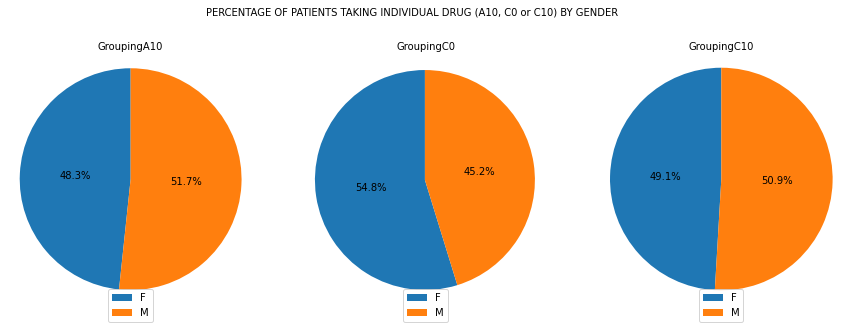

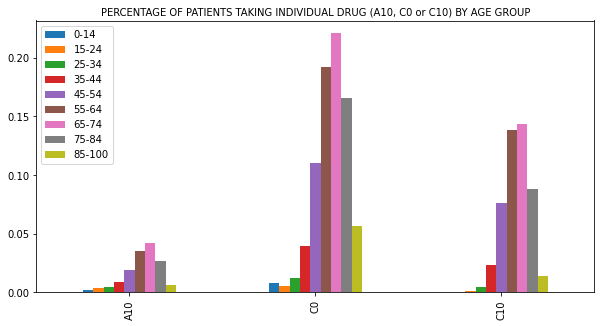

In [ ]:
genders = []
counts = {}
for i, value in zip(range(3), ['A10', 'C0', 'C10']) :
    genders, counts['{}'.format(value)] = np.unique(groups[i].sex, return_counts = True)
df = pd.DataFrame(counts, index = genders).T
dfp = pd.DataFrame().reindex_like(df)
for i in range(3):
    dfp.iloc[i] = [x/sum(df.iloc[i])*100 for x in df.iloc[i]]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) BY GENDER', fontsize=10)
for each, value, ax in zip(['GroupingA10', 'GroupingC0', 'GroupingC10'], range(3), (ax1, ax2, ax3)):
    ax.pie(dfp.iloc[value], labeldistance = .53, pctdistance = .5, autopct='%1.1f%%', startangle=90)
    ax.legend(genders, loc="lower center", bbox_to_anchor=(.50,-.1))
    ax.set_title(each, loc='center', fontsize=10)
    ax.axis('square')

agegroups = []
counts = {}
for i, value in zip(range(3), ['A10', 'C0', 'C10']) :
    agegroups, counts['{}'.format(value)] = np.unique(groups[i].Agegrouping, return_counts = True)
df = pd.DataFrame(counts, index = agegroups).T/len(data)
df.plot.bar(figsize=(10,5))
plt.title('PERCENTAGE OF PATIENTS TAKING INDIVIDUAL DRUG (A10, C0 or C10) BY AGE GROUP', fontsize=10)
plt.show()

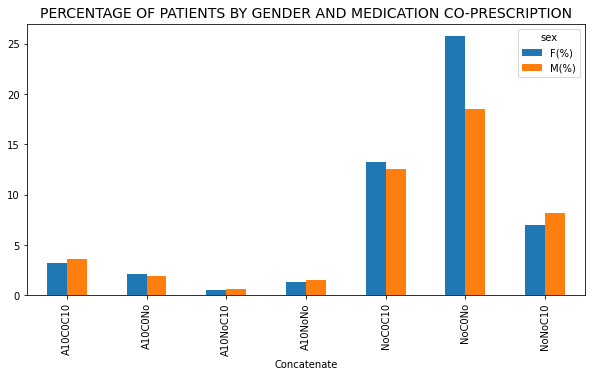

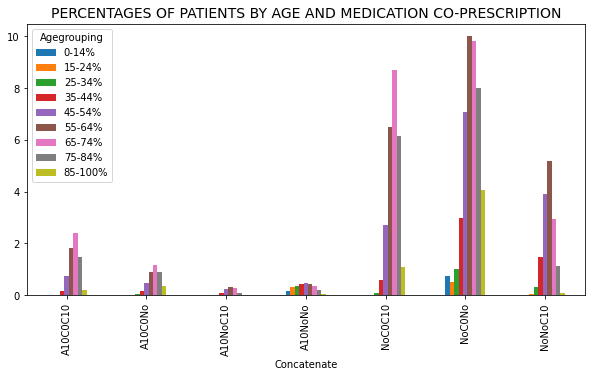

In [ ]:
med_sex = data.groupby(['Concatenate','sex']).size().unstack(fill_value=0)
med_sex['F(%)'] = med_sex.iloc[:,0]/len(data)*100
med_sex['M(%)'] = med_sex.iloc[:,1]/len(data)*100
med_sex.iloc[:,2:].plot.bar(figsize=(10,5))
plt.title('PERCENTAGE OF PATIENTS BY GENDER AND MEDICATION CO-PRESCRIPTION', fontsize=14)
plt.show()

med_age = data.groupby(['Concatenate','Agegrouping']).size().unstack(fill_value=0)
for i, col in enumerate(med_age.columns):
  med_age[col+'%'] = med_age.iloc[:,i]/len(data)*100

med_age.iloc[:,9:].plot.bar(figsize=(10,5))
plt.title('PERCENTAGES OF PATIENTS BY AGE AND MEDICATION CO-PRESCRIPTION', fontsize=14)
plt.show()

### Mortality

In [23]:
data['dead'] = data['dead'].replace({'YES':1, 'NO':0}).astype('uint8')

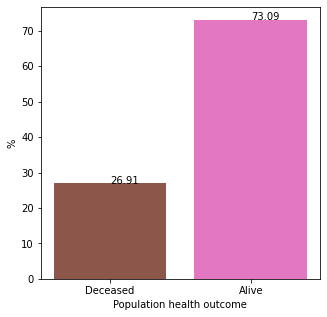

In [24]:
neg, pos = np.bincount(data['dead'])
plt.figure(figsize=(5,5))
plt.bar(['Deceased', 'Alive'], height=[pos/len(data)*100, neg/len(data)*100], color = [colors[5], colors[6]])
for i, v in zip(range(2), (pos/len(data)*100, neg/len(data)*100)):
    plt.text(x = i, y = v, s=str(round(v,2)), fontsize=10)
plt.xlabel('Population health outcome')
plt.ylabel('%')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig5-1.pdf')
plt.show()

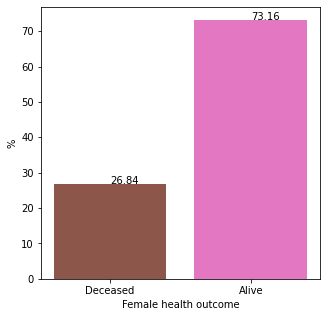

In [25]:
neg, pos = np.bincount(data[(data['sex']=='F')]['dead'])
plt.figure(figsize=(5,5))
plt.bar(['Deceased', 'Alive'], height=[pos/len(data[(data['sex']=='F')])*100, neg/len(data[(data['sex']=='F')])*100], color = [colors[5], colors[6]])
for i, v in zip(range(2), (pos/len(data[(data['sex']=='F')])*100, neg/len(data[(data['sex']=='F')])*100)):
    plt.text(x = i, y = v, s=str(round(v,2)), fontsize=10)
plt.xlabel('Female health outcome')
plt.ylabel('%')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig5-2.pdf')
plt.show()

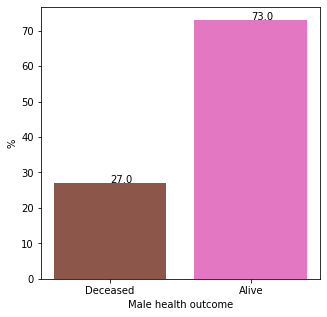

In [26]:
neg, pos = np.bincount(data[(data['sex']=='M')]['dead'])
plt.figure(figsize=(5,5))
plt.bar(['Deceased', 'Alive'], height=[pos/len(data[(data['sex']=='M')])*100, neg/len(data[(data['sex']=='M')])*100], color = [colors[5], colors[6]])
for i, v in zip(range(2), (pos/len(data[(data['sex']=='M')])*100, neg/len(data[(data['sex']=='M')])*100)):
    plt.text(x = i, y = v, s=str(round(v,2)), fontsize=10)
plt.xlabel('Male health outcome')
plt.ylabel('%')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig5-3.pdf')
plt.show()

sex
F    26.84
M    27.00
Name: mortality(%), dtype: float64


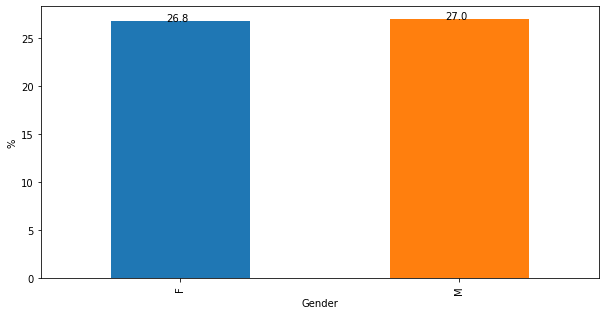

Agegrouping
0-14      15.19
15-24     11.88
25-34     10.58
35-44      8.07
45-54      8.22
55-64     12.24
65-74     25.01
75-84     54.96
85-100    90.63
Name: mortality(%), dtype: float64


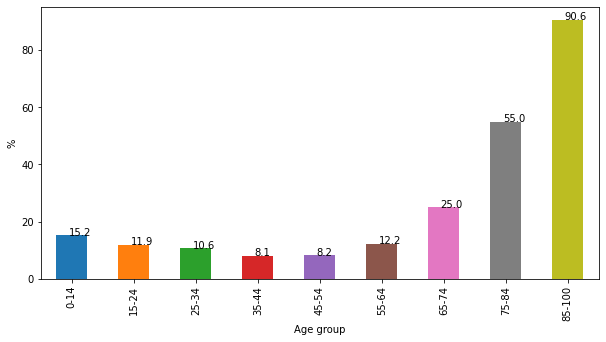

Concatenate
A10C0C10    36.78
A10C0No     42.17
A10NoC10    17.88
A10NoNo     19.74
NoC0C10     27.28
NoC0No      29.56
NoNoC10     12.03
Name: mortality(%), dtype: float64


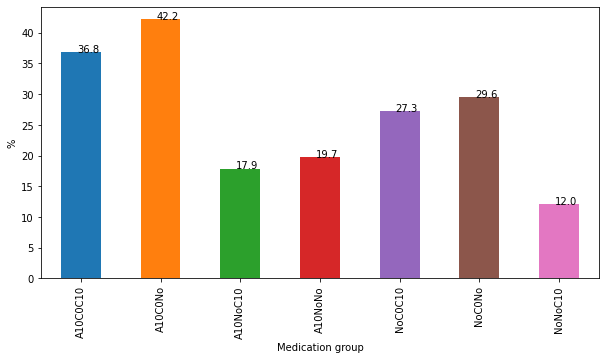

In [28]:
mortality = data[['sex', 'dead']]
mortality = pd.pivot_table(mortality, values = ['dead'], index=['sex'], 
                       columns = ['dead'], aggfunc=['size'])
mortality = mortality.replace(np.nan, 0)
mortality['mortality(%)'] = mortality.iloc[:,1]/(mortality.iloc[:,1] + mortality.iloc[:,0])*100
print(str(round(mortality['mortality(%)'],2)))
mortality['mortality(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(mortality['mortality(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.ylabel('%')
plt.xlabel('Gender')
plt.show()

mortality = data[['Agegrouping', 'dead']]
mortality = pd.pivot_table(mortality, values = ['dead'], index=['Agegrouping'], 
                       columns = ['dead'], aggfunc=['size'])
mortality = mortality.replace(np.nan, 0)
mortality['mortality(%)'] = mortality.iloc[:,1]/(mortality.iloc[:,1] + mortality.iloc[:,0])*100
print(str(round(mortality['mortality(%)'],2)))
mortality['mortality(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(mortality['mortality(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.ylabel('%')
plt.xlabel('Age group')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig6.pdf')
plt.show()

mortality = data[['Concatenate', 'dead']]
mortality = pd.pivot_table(mortality, values = ['dead'], index=['Concatenate'], 
                       columns = ['dead'], aggfunc=['size'])
mortality = mortality.replace(np.nan, 0)
mortality['mortality(%)'] = mortality.iloc[:,1]/(mortality.iloc[:,1] + mortality.iloc[:,0])*100
print(str(round(mortality['mortality(%)'],2)))
mortality['mortality(%)'].plot.bar(figsize=(10,5), color = colors)
for i, v in enumerate(mortality['mortality(%)']):
    plt.text(x = i-.05, y = v, s=str(round(v,1)), fontsize=10)
plt.ylabel('%')
plt.xlabel('Medication group')
plt.savefig('/content/drive/My Drive/Medicare Analysis/JMIR paper preparation/fig7.pdf')
plt.show()

sex  Agegrouping
F    0-14            9.29
     15-24           8.02
     25-34           7.90
     35-44           6.21
     45-54           6.62
     55-64           9.23
     65-74          20.40
     75-84          51.74
     85-100         89.70
M    0-14           18.12
     15-24          16.78
     25-34          13.52
     35-44           9.60
     45-54           9.63
     55-64          15.24
     65-74          30.10
     75-84          59.91
     85-100         93.32
Name: mortality(%), dtype: float64


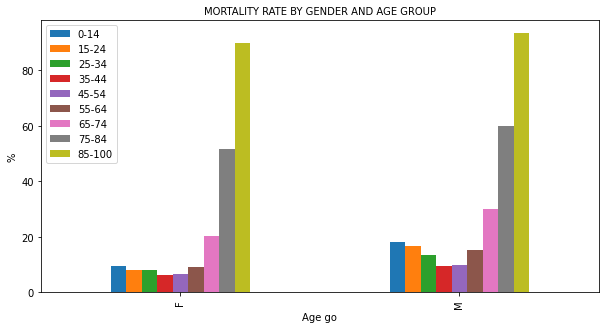

Concatenate  sex
A10C0C10     F      35.27
             M      38.15
A10C0No      F      41.78
             M      42.57
A10NoC10     F      16.01
             M      19.52
A10NoNo      F      16.63
             M      22.49
NoC0C10      F      26.91
             M      27.66
NoC0No       F      29.60
             M      29.50
NoNoC10      F      10.89
             M      13.01
Name: mortality(%), dtype: float64


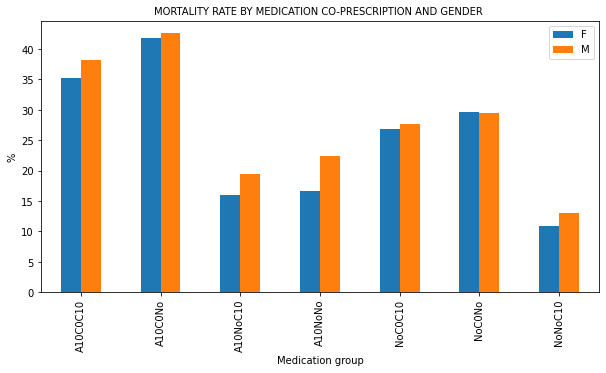

Agegrouping  Concatenate
0-14         A10C0C10       22.22
             A10C0No         0.00
             A10NoC10       12.50
             A10NoNo         4.91
             NoC0C10        25.93
             NoC0No         17.26
             NoNoC10        20.00
15-24        A10C0C10       26.67
             A10C0No         2.02
             A10NoC10       17.86
             A10NoNo         6.29
             NoC0C10        19.61
             NoC0No         14.82
             NoNoC10        15.38
25-34        A10C0C10       16.13
             A10C0No        11.83
             A10NoC10        7.41
             A10NoNo         8.00
             NoC0C10        10.32
             NoC0No         11.11
             NoNoC10        11.53
35-44        A10C0C10       10.92
             A10C0No        10.21
             A10NoC10        8.06
             A10NoNo         7.38
             NoC0C10         7.03
             NoC0No          8.00
             NoNoC10         8.25
45-54        A10C0C10  

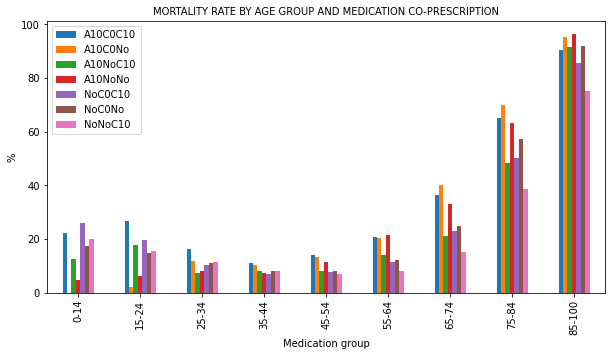

In [ ]:
mortality = data[['Agegrouping','sex', 'dead']]
mortality = pd.pivot_table(mortality, values = ['dead'], index=['sex', 'Agegrouping'], 
                       columns = ['dead'], aggfunc=['size'])
mortality = mortality.replace(np.nan, 0)
mortality['mortality(%)'] = mortality.iloc[:,1]/(mortality.iloc[:,1] + mortality.iloc[:,0])*100
print(str(round(mortality['mortality(%)'],2)))
mortality['mortality(%)'].unstack(fill_value=0).plot.bar(figsize=(10,5))
plt.ylabel('%')
plt.xlabel('Age go')
plt.title('MORTALITY RATE BY GENDER AND AGE GROUP', fontsize=10)
plt.legend(loc='best')
plt.show()

mortality = data[['sex','Concatenate', 'dead']]
mortality = pd.pivot_table(mortality, values = ['dead'], index=['Concatenate','sex'], 
                       columns = ['dead'], aggfunc=['size'])
mortality = mortality.replace(np.nan, 0)
mortality['mortality(%)'] = mortality.iloc[:,1]/(mortality.iloc[:,1] + mortality.iloc[:,0])*100
print(str(round(mortality['mortality(%)'],2)))
mortality['mortality(%)'].unstack(fill_value=0).plot.bar(figsize=(10,5))
plt.ylabel('%')
plt.xlabel('Medication group')
plt.title('MORTALITY RATE BY MEDICATION CO-PRESCRIPTION AND GENDER ', fontsize=10)
plt.legend(loc='best')
plt.show()

mortality = data[['Agegrouping','Concatenate', 'dead']]
mortality = pd.pivot_table(mortality, values = ['dead'], index=['Agegrouping','Concatenate'], 
                       columns = ['dead'], aggfunc=['size'])
mortality = mortality.replace(np.nan, 0)
mortality['mortality(%)'] = mortality.iloc[:,1]/(mortality.iloc[:,1] + mortality.iloc[:,0])*100
pd.set_option('display.max_rows', None)
print(str(round(mortality['mortality(%)'],2)))
mortality['mortality(%)'].unstack(fill_value=0).plot.bar(figsize=(10,5))
plt.ylabel('%')
plt.xlabel('Medication group')
plt.title('MORTALITY RATE BY AGE GROUP AND MEDICATION CO-PRESCRIPTION', fontsize=10)
plt.legend(loc='best')
plt.show()
